<table>
    <tr>
        <td>
            <img src='https://cdn0.iconfinder.com/data/icons/isometric-city-basic-transport/48/car-front-01-128.png' style='display:inline' />
        </td>
        <td>
    <img src='http://rodrigob.github.io/are_we_there_yet/build/images/cifar_10.png?1363085077' width="100" />
        </td>
    </tr>
</table>

# LINCOLN DataScience Challenge #2
### CIFAR-10 - Image Recongnition

# Purpose
The goal of this notebook is to fit a convolutional network to the dataset CIFAR-10 using the Keras Framework and a Residual Network architecture.

# Documentation
+ Deep Residual Learning for Image Recognition https://arxiv.org/pdf/1512.03385.pdf
+ Identity Mappings in Deep Residual Networks https://arxiv.org/pdf/1603.05027.pdf
+ GitHub https://github.com/raghakot/keras-resnet
+ State of art http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

# Modules

In [1]:
from scipy.misc import imread, imsave, imresize, imshow, fromimage
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn import preprocessing
from convNet import imfunc as imf

In [2]:
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, merge, Add, LeakyReLU
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

# Dynamic memory allocation on gpu
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

Using TensorFlow backend.


# Loading images and labels

### Images

In [3]:
start_time = time.time()

Xtr = np.zeros((50000,32,32,3), dtype="float32")
for img in range(0,50000):
    Xtr[img] = imread('./CIFAR-10/train/' + str(img+1) + '.png')

print("Loading time: %s seconds" % round(time.time() - start_time))

Loading time: 73 seconds


### Labels

In [4]:
# Training label
Ytr = np.genfromtxt('./CIFAR-10/trainLabels.csv', dtype = 'str', delimiter = ',', skip_header = 1)

# Label dictionnary
label = dict(zip(np.unique(Ytr[:,1]),range(10)))
label_inv = dict(zip(range(10),np.unique(Ytr[:,1])))

# Label list
Ytr = [label[i] for i in Ytr[:,1]]
Ytr_label = [label_inv[i] for i in Ytr]

### Plotting some images

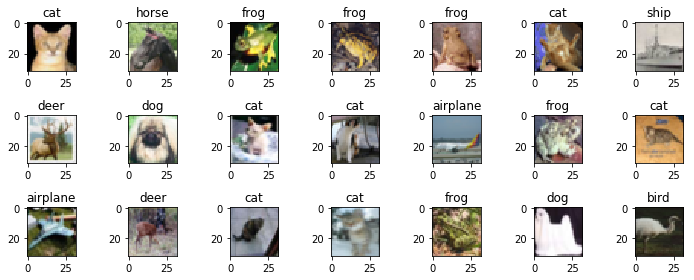

In [5]:
# number of image per row
n = 7
idx = np.random.choice(len(Ytr),size=n*3,replace=False)

# Initialization of plots - 2 row and n col
fig, axe = plt.subplots(3,n)

# Assigning image for each subplot
for i in range(n*3):
    axe[i//n,i%n].imshow(Xtr[idx[i]].astype("uint8"))
    axe[i//n,i%n].set_title(Ytr_label[idx[i]])

# Setting figure width and layout
fig.set_figwidth(10)
fig.tight_layout()
plt.show()

# Residual Neural Network - Setup

### Train / test set

In [40]:
N = 10000

Y = Ytr[:N]
X = Xtr[:N,]

Y_test = Ytr[N:N+1000]
X_test = Xtr[N:N+1000,]

### Label recoding

In [41]:
# Recoding
encode = preprocessing.LabelEncoder()
encode.fit(Y)

Y = encode.transform(Y) 
Y_test = encode.transform(Y_test) 

# Creating dummy variable
Y = np_utils.to_categorical(Y, 10)
Y_test= np_utils.to_categorical(Y_test, 10)

### Scaling

In [42]:
Xstd = np.std(X,axis = 0)

# Reducing features with non-null std
X[:, Xstd>0] /= Xstd[Xstd>0]
X_test[:, Xstd>0] /= Xstd[Xstd>0]

### Residual Network functions
Those functions have been taken from the **Raghakot GitHub** (given in the documentation section) and adapt to Keras V2.

In [43]:
def rnpa_bottleneck_layer(input_tensor, nb_filters, filter_sz, stage,
    init='glorot_normal', reg=0.0, use_shortcuts=True):

    nb_in_filters, nb_bottleneck_filters = nb_filters

    bn_name = 'bn' + str(stage)
    conv_name = 'conv' + str(stage)
    relu_name = 'relu' + str(stage)
    merge_name = '+' + str(stage)

    # batchnorm-relu-conv, from nb_in_filters to nb_bottleneck_filters via 1x1 conv
    if stage>1: # first activation is just after conv1
        x = BatchNormalization(axis=1)(input_tensor)
        x = LeakyReLU(alpha=0.01)(x)
    else:
        x = input_tensor

    x = Conv2D(
            nb_bottleneck_filters, (1, 1),
            kernel_initializer=init,
            kernel_regularizer=l2(reg),
            use_bias=False
        )(x)
    
    # batchnorm-relu-conv, from nb_bottleneck_filters to nb_bottleneck_filters via FxF conv
    x = BatchNormalization(axis=1)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2D(
            nb_bottleneck_filters, (filter_sz, filter_sz),
            padding='same',
            kernel_initializer=init,
            kernel_regularizer=l2(reg),
            use_bias = False
        )(x)
   
    # batchnorm-relu-conv, from nb_in_filters to nb_bottleneck_filters via 1x1 conv
    x = BatchNormalization(axis=1)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2D(nb_in_filters, (1, 1),
            kernel_initializer=init, kernel_regularizer=l2(reg)
        )(x)

    # merge
    if use_shortcuts:
        x = Add()([x, input_tensor])
    
    return x

def ResNetPreAct(input_shape=(3,32,32), nb_classes=10,
        layer1_params=(5,64,2),
        res_layer_params=(3,16,3),
        final_layer_params=None,
        init='glorot_uniform', reg=0.0, use_shortcuts=True
    ):
    """
    Return a new Residual Network using full pre-activation based on the work in
    "Identity Mappings in Deep Residual Networks"  by He et al
    http://arxiv.org/abs/1603.05027
    The following network definition achieves 92.0% accuracy on CIFAR-10 test using
    `adam` optimizer, 100 epochs, learning rate schedule of 1e.-3 / 1.e-4 / 1.e-5 with
    transitions at 50 and 75 epochs:
    ResNetPreAct(layer1_params=(3,128,2),res_layer_params=(3,32,25),reg=reg)
    
    Removed max pooling and using just stride in first convolutional layer. Motivated by
    "Striving for Simplicity: The All Convolutional Net"  by Springenberg et al
    (https://arxiv.org/abs/1412.6806) and my own experiments where I observed about 0.5%
    improvement by replacing the max pool operations in the VGG-like cifar10_cnn.py example
    in the Keras distribution.
    
    Parameters
    ----------
    input_dim : tuple of (C, H, W)
    nb_classes: number of scores to produce from final affine layer (input to softmax)
    layer1_params: tuple of (filter size, num filters, stride for conv)
    res_layer_params: tuple of (filter size, num res layer filters, num res stages)
    final_layer_params: None or tuple of (filter size, num filters, stride for conv)
    init: type of weight initialization to use
    reg: L2 weight regularization (or weight decay)
    use_shortcuts: to evaluate difference between residual and non-residual network
    """
    sz_L1_filters, nb_L1_filters, stride_L1 = layer1_params
    sz_res_filters, nb_res_filters, nb_res_stages = res_layer_params
    
    use_final_conv = (final_layer_params is not None)
    if use_final_conv:
        sz_fin_filters, nb_fin_filters, stride_fin = final_layer_params
        sz_pool_fin = input_shape[1] / (stride_L1 * stride_fin)
    else:
        sz_pool_fin = input_shape[1] / (stride_L1)

    img_input = Input(shape=input_shape,name='cifar')
   
    x = Conv2D(
            nb_L1_filters, (sz_L1_filters, sz_L1_filters),
            padding='same',
            strides=(stride_L1, stride_L1),
            kernel_initializer=init,
            kernel_regularizer=l2(reg),
            use_bias=False
        )(img_input)
    x = BatchNormalization(axis=1)(x)
    x = LeakyReLU(alpha=0.01)(x)
    
    for stage in range(1,nb_res_stages+1):
        x = rnpa_bottleneck_layer(
                x,
                (nb_L1_filters, nb_res_filters),
                sz_res_filters, 
                stage,
                init=init, 
                reg=reg, 
                use_shortcuts=use_shortcuts
            )
        
    x = BatchNormalization(axis=1)(x)
    x = LeakyReLU(alpha=0.01)(x)

    if use_final_conv:
        x = Conv2D(
                nb_fin_filters, (sz_fin_filters, sz_fin_filters),
                padding='same',
                strides=(stride_fin, stride_fin),
                kernel_initializer=init,
                kernel_regularizer=l2(reg)
            )(x)

    x = AveragePooling2D((2,2))(x)
    x=Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(nb_classes, activation='softmax')(x)
    return Model(img_input, x)


### Initialization / Compilation of model

In [48]:
model=ResNetPreAct(input_shape=(32,32,3), nb_classes=10,
        layer1_params=(5,32,2),
        res_layer_params=(5,16,10),
        final_layer_params=None,
        init='glorot_uniform', reg=0.0, use_shortcuts=True
    )

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001),metrics=['accuracy'])

### Learning rate decay function

In [49]:
def step_decay(epoch):
    if epoch >= 75:
        lrate = 0.00001
    elif epoch >= 50:
        lrate = 0.0001
    else :
        lrate = 0.001
    return lrate
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

### Data augmentation

In [50]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True
)
datagen.fit(X)


# Residual Neural Network - Training

### With data augmentation

In [ ]:
start_time = time.time()
history=model.fit_generator(datagen.flow(X, 
                                         Y,
                                         batch_size=128),   
                            validation_data=(X_test,Y_test),
                            #callbacks=callbacks_list,
                            steps_per_epoch=len(X) / 128,
                            epochs=100,
                            verbose=2)
end_time = time.time()

Epoch 1/100
9s - loss: 1.0120 - acc: 0.6409 - val_loss: 1.0457 - val_acc: 0.6550
Epoch 2/100


### Without data augmentation

In [23]:
start_time = time.time()
history=model.fit(X, Y, 
                  batch_size=128,
                  epochs=100, 
                  validation_split=0.2,
                  callbacks=callbacks_list,
                  verbose=1)
end_time = time.time()

Train on 32000 samples, validate on 8000 samples
Epoch 1/100
  640/32000 [..............................] - ETA: 129s - loss: 2.8994 - acc: 0.1250

KeyboardInterrupt: 

### Processing time

In [108]:
print('Processing time : %.2f heures' % ((end_time - start_time)/3600))

Processing time : 6.93 heures


# Residual Neural Network - Results

### Accuracy / Score

In [52]:
score = model.evaluate(X_test, Y_test,
batch_size=1000, verbose=2)

print("Test score: %.2f" % (score[0]))
print('Test accuracy: %.2f' % (score[1] * 100))

Test score: 1.04
Test accuracy: 65.30


### Plotting training process

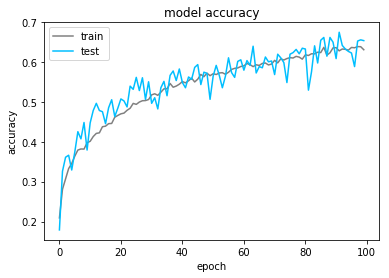

In [53]:
plt.plot(history.history['acc'],c="grey")
plt.plot(history.history['val_acc'],c="deepskyblue")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

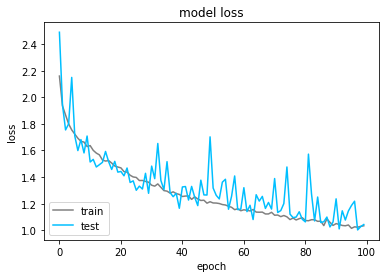

In [54]:
plt.plot(history.history['loss'],c="grey")
plt.plot(history.history['val_loss'],c="deepskyblue")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()